In [1]:
from pathlib import Path 
import sys 
import warnings
sys.path.append(str(Path.cwd().parent))

In [2]:
# versioning
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
from utils import predictors, data_loading as dl
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
MAX_PLOT_HORIZON = 500
MAX_PLOT_TRAIN = 100

In [5]:
sunspots = dl.DataLoader(dl.DATASET.SUNSPOTS)
electricity = dl.DataLoader(dl.DATASET.ELECTRICITY)
mackey_glass = dl.DataLoader(dl.DATASET.MACKEY_GLASS)
temperature = dl.DataLoader(dl.DATASET.TEMPERATURE)

In [6]:
def plot_predictions(y_train, y_test, y_hat_test):
    xrange_train = np.arange(y_train.shape[0])
    xrange_test = np.arange(y_train.shape[0], y_train.shape[0] + y_test.shape[0])
    sns.lineplot(y=y_train, x=xrange_train, label="train")
    sns.lineplot(y=y_test, x=xrange_test, label="test")
    if y_hat_test is not None:
        sns.lineplot(y=y_hat_test, x=xrange_test, label="prediction")
    # plot vertical dotted line
    plt.axvline(x=y_train.shape[0], linestyle="--", color="black")
    plt.legend()

In [7]:
def calculate_rmse(y_test, y_hat_test):
    se = (y_hat_test - y_test) ** 2
    predicted_days = np.arange(1, se.shape[0]+1)
    rmse = np.sqrt(np.cumsum(se) / predicted_days)

    for h in [10, 50, 100, 200, 300, 1000, y_test.shape[0]]:
        if h > y_test.shape[0]:
            continue
        print(f"{h} steps horizon - rmse = {round(rmse[h-1], 4)}")

    sns.lineplot(y=rmse, x=predicted_days, label="rmse")

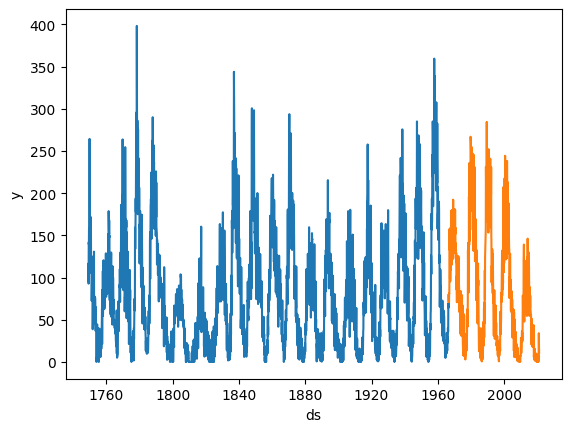

In [8]:
sns.lineplot(data=sunspots.train_df, x="ds", y="y")
sns.lineplot(data=sunspots.val_df, x="ds", y="y")
plt.show()

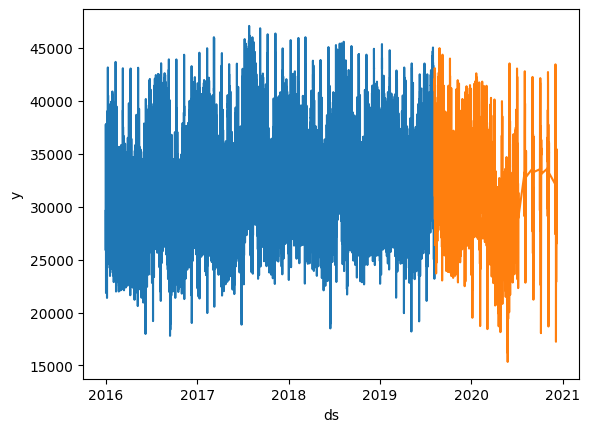

In [6]:
sns.lineplot(data=electricity.train_df, x="ds", y="y")
sns.lineplot(data=electricity.val_df, x="ds", y="y")
plt.show()

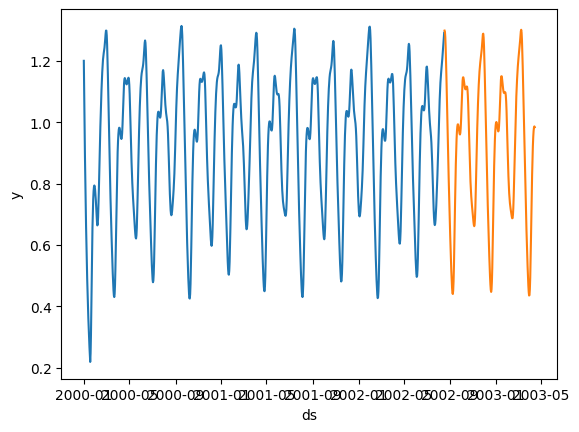

In [7]:
sns.lineplot(data=mackey_glass.train_df, x="ds", y="y")
sns.lineplot(data=mackey_glass.val_df, x="ds", y="y")
plt.show()

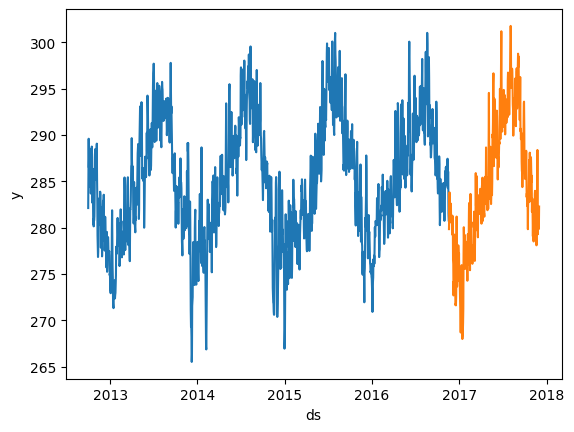

In [8]:
sns.lineplot(data=temperature.train_df, x="ds", y="y")
sns.lineplot(data=temperature.val_df, x="ds", y="y")
plt.show()

# Forecasting with XGBoost

## **1. Autoregression**

## Train model

In [8]:
models = {}
datasets = [sunspots, electricity, mackey_glass, temperature]
xgboost_params = {
    dl.DATASET.SUNSPOTS: {
        "n_estimators": 300,
        "max_depth": 10,
        "objective": "reg:squarederror",
        "booster": "gbtree",
        "include_hours": False,
        "lags": None,
        "mode": 1
    },
    dl.DATASET.ELECTRICITY: {
        "n_estimators": 1000,
        "max_depth": 5,
        "objective": "reg:squarederror",
        "booster": "gbtree",
        "include_hours": True,
        "lags": None,
        "mode": 1
    },
    dl.DATASET.MACKEY_GLASS: {
        "n_estimators": 100,
        "max_depth": 10,
        "objective": "reg:squarederror",
        "booster": "gbtree",
        "include_hours": False,
        "lags": None,
        "mode": 1
    },
    dl.DATASET.TEMPERATURE: {
       "n_estimators": 1000,
        "max_depth": 5,
        "objective": "reg:squarederror",
        "booster": "gbtree",
        "include_hours": False,
        "lags": None,
        "mode": 1
    }
}

for dataset in datasets:
    print(dataset.name)
    X_train = dataset.X_train
    y_train = dataset.y_train
    print(dataset.df_train.shape)
    params = xgboost_params[dataset.name]
    model = predictors.XGBoostPredictor(**params)
    model.fit(X=X_train, y=y_train)
    models[dataset.name] = model

DATASET.SUNSPOTS
(2612, 2)
DATASET.ELECTRICITY
(31564, 2)
DATASET.MACKEY_GLASS
(960, 2)
DATASET.TEMPERATURE
(1509, 2)


## Evaluate model

DATASET.SUNSPOTS


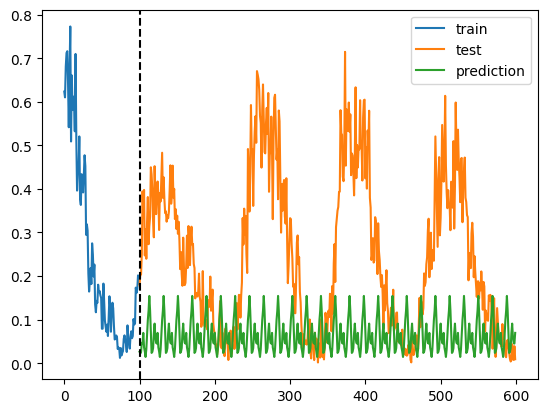

10 steps horizon - rmse = 0.251
50 steps horizon - rmse = 0.3035
100 steps horizon - rmse = 0.2386
200 steps horizon - rmse = 0.289
300 steps horizon - rmse = 0.2867
653 steps horizon - rmse = 0.2354


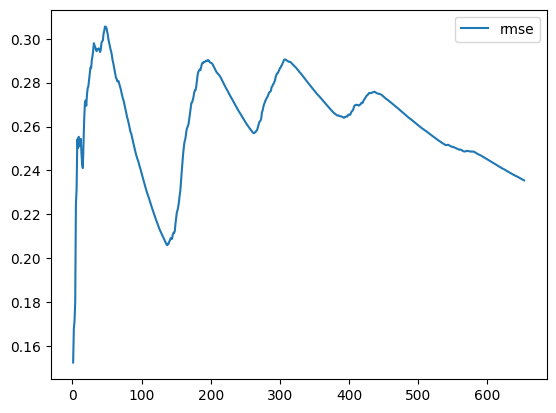


******************************

DATASET.ELECTRICITY


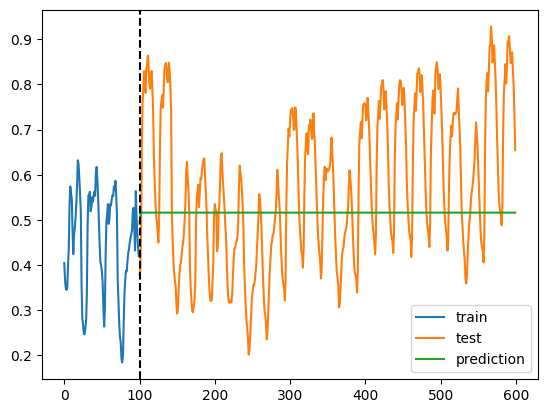

10 steps horizon - rmse = 0.2307
50 steps horizon - rmse = 0.2339
100 steps horizon - rmse = 0.1877
200 steps horizon - rmse = 0.1658
300 steps horizon - rmse = 0.1566
1000 steps horizon - rmse = 0.1717
7891 steps horizon - rmse = 0.1808


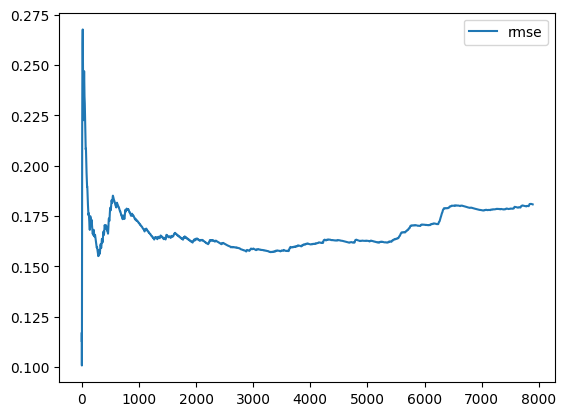


******************************

DATASET.MACKEY_GLASS


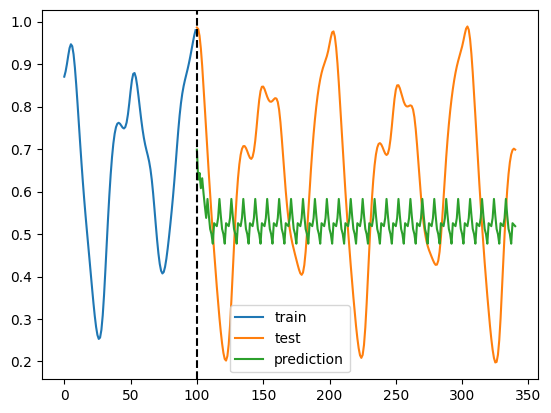

10 steps horizon - rmse = 0.2589
50 steps horizon - rmse = 0.2181
100 steps horizon - rmse = 0.2268
200 steps horizon - rmse = 0.2339
241 steps horizon - rmse = 0.2406


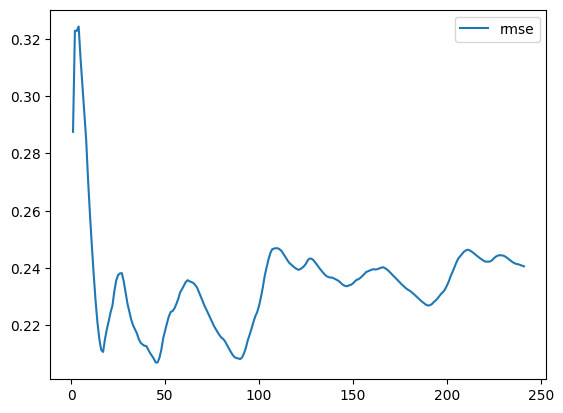


******************************

DATASET.TEMPERATURE


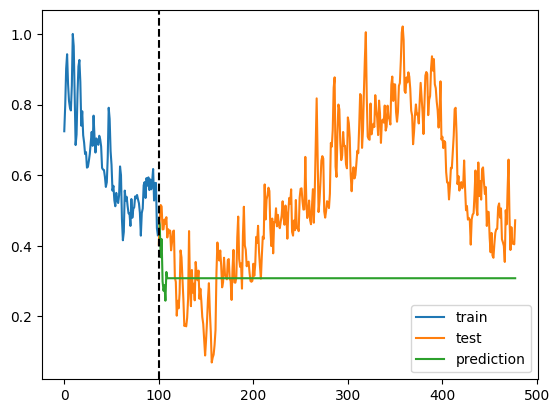

10 steps horizon - rmse = 0.1439
50 steps horizon - rmse = 0.1069
100 steps horizon - rmse = 0.1018
200 steps horizon - rmse = 0.1924
300 steps horizon - rmse = 0.3232
378 steps horizon - rmse = 0.3085


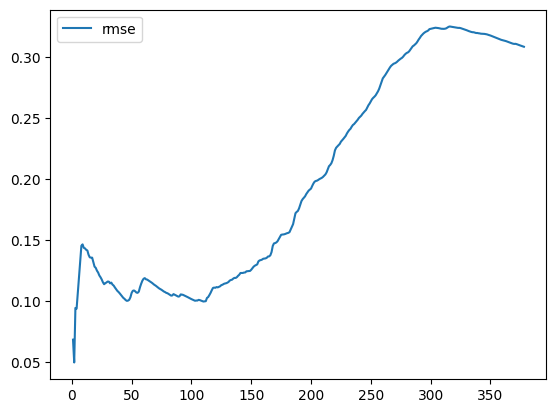


******************************



In [14]:
forecasts = {}
for dataset in datasets:
    y_val = dataset.y_val
    model = models[dataset.name]
    y_pred = model.forecast(y_val)

    print(dataset.name)
    
    plot_predictions(dataset.y_train[-MAX_PLOT_TRAIN: ].flatten(), y_val[:MAX_PLOT_HORIZON].flatten(), y_pred[:MAX_PLOT_HORIZON].flatten())
    plt.show()

    calculate_rmse(y_val.flatten(), y_pred.flatten())
    plt.show()
    print()
    print("*" * 30)
    print()

## **2. Multi-horizon with future covariates**

## Train model

In [11]:
models = {}
datasets = [sunspots, electricity, mackey_glass, temperature]
xgboost_params = {
    dl.DATASET.SUNSPOTS: {
        "n_estimators": 300,
        "max_depth": 10,
        "objective": "reg:squarederror",
        "booster": "gbtree",
        "include_hours": False,
        "lags": {
            "50 years lag": "18262 days",
            "40 years lag": "14610 days",
            "30 years lag": "10958 days"
        },
        "mode": 3
    },
    dl.DATASET.ELECTRICITY: {
        "n_estimators": 1000,
        "max_depth": 5,
        "objective": "reg:squarederror",
        "booster": "gbtree",
        "include_hours": True,
        "lags": {
            "8 months lag": "242 days",
            "6 months lag": "182 days",
            "4 months lag": "91 days"
        },
        "mode": 3
    },
    dl.DATASET.MACKEY_GLASS: {
        "n_estimators": 100,
        "max_depth": 10,
        "objective": "reg:squarederror",
        "booster": "gbtree",
        "include_hours": False,
        "lags": {
            "300 days lag": "300 days",
            "2 months lag": "61 days",
            "3 months lag": "91 days"
        },
        "mode": 3
    },
    dl.DATASET.TEMPERATURE: {
       "n_estimators": 1000,
        "max_depth": 5,
        "objective": "reg:squarederror",
        "booster": "gbtree",
        "include_hours": False,
        "lags": {
            "4 months lag": "91 days",
            "1 month lag": "30 days",
            "15 days lag": "15 days"
        },
        "mode": 3
    }
}

for dataset in datasets:
    print(dataset.name)
    df_train = dataset.y_train_df
    print(df_train.shape)
    params = xgboost_params[dataset.name]
    model = predictors.XGBoostPredictor(**params)
    model.fit(df=df_train)
    models[dataset.name] = model    

DATASET.SUNSPOTS
(2612, 2)


Exception ignored in: <function Booster.__del__ at 0x0000012E8856C040>
Traceback (most recent call last):
  File "c:\Users\Kamil\anaconda3\envs\.ed\lib\site-packages\xgboost\core.py", line 1653, in __del__
    _check_call(_LIB.XGBoosterFree(self.handle))
  File "c:\Users\Kamil\anaconda3\envs\.ed\lib\site-packages\xgboost\core.py", line 279, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [07:44:03] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:752: DMatrix/Booster has not been initialized or has already been disposed.


DATASET.ELECTRICITY
(31564, 2)
DATASET.MACKEY_GLASS
(960, 2)
DATASET.TEMPERATURE
(1509, 2)


## Evaluate model

DATASET.SUNSPOTS


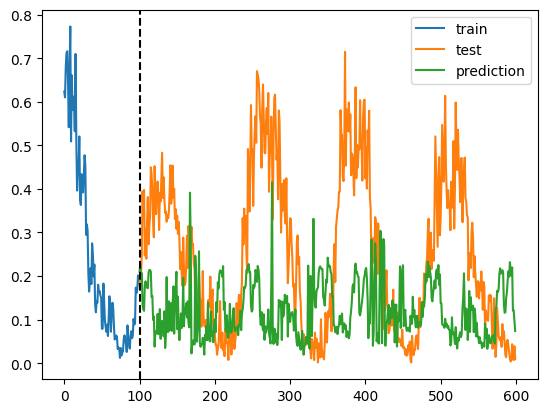

10 steps horizon - rmse = 0.1464
50 steps horizon - rmse = 0.2483
100 steps horizon - rmse = 0.1986
200 steps horizon - rmse = 0.246
300 steps horizon - rmse = 0.25
653 steps horizon - rmse = 0.2057


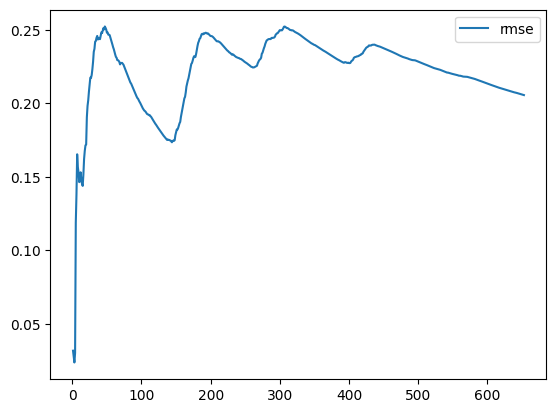


******************************

DATASET.ELECTRICITY


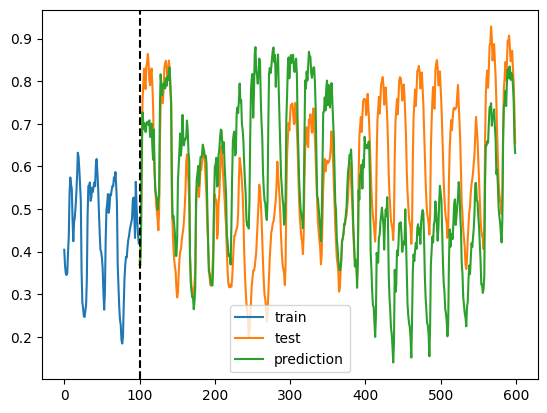

10 steps horizon - rmse = 0.0839
50 steps horizon - rmse = 0.0767
100 steps horizon - rmse = 0.0975
200 steps horizon - rmse = 0.1935
300 steps horizon - rmse = 0.1682
1000 steps horizon - rmse = 0.1509
7891 steps horizon - rmse = 0.1318


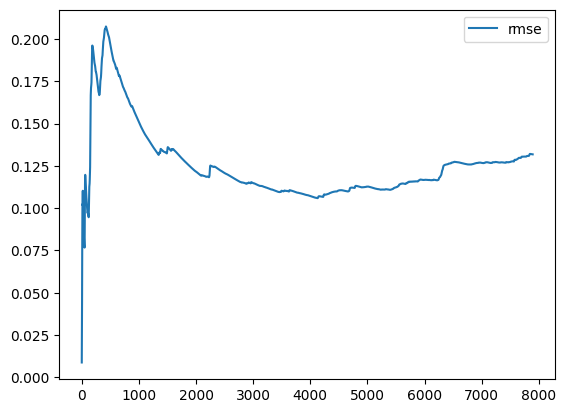


******************************

DATASET.MACKEY_GLASS


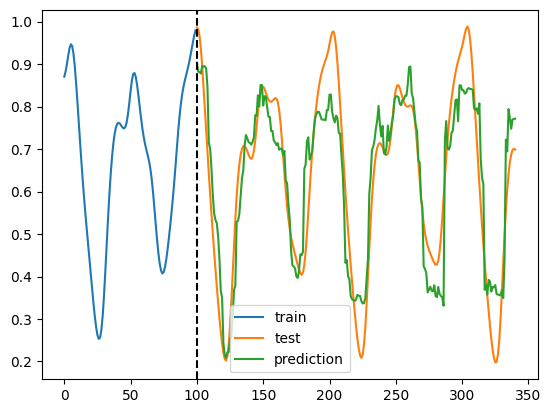

10 steps horizon - rmse = 0.0949
50 steps horizon - rmse = 0.083
100 steps horizon - rmse = 0.0854
200 steps horizon - rmse = 0.0873
241 steps horizon - rmse = 0.0918


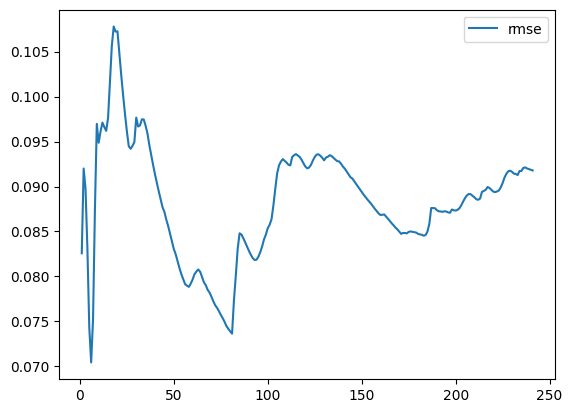


******************************

DATASET.TEMPERATURE


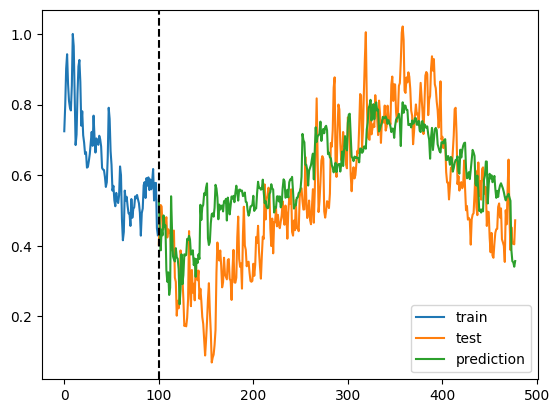

10 steps horizon - rmse = 0.088
50 steps horizon - rmse = 0.1588
100 steps horizon - rmse = 0.199
200 steps horizon - rmse = 0.1654
300 steps horizon - rmse = 0.1488
378 steps horizon - rmse = 0.1415


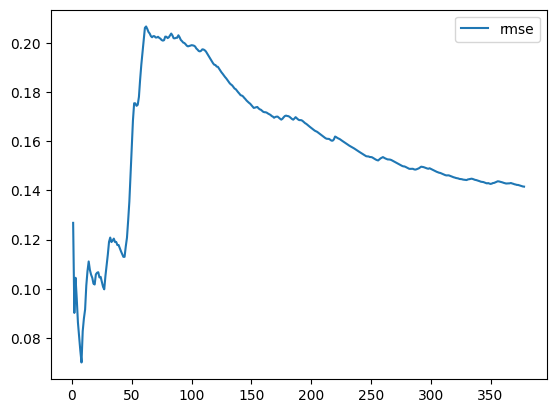


******************************



In [12]:
forecasts = {}
for dataset in datasets:
    y_val = dataset.y_val
    df_val = pd.DataFrame({"ds": dataset.y_val_df.ds})
    model = models[dataset.name]
    y_pred = model.forecast(df_val)

    print(dataset.name)
    
    plot_predictions(dataset.y_train[-MAX_PLOT_TRAIN: ].flatten(), y_val[:MAX_PLOT_HORIZON].flatten(), y_pred[:MAX_PLOT_HORIZON].flatten())
    plt.show()

    calculate_rmse(y_val.flatten(), y_pred.flatten())
    plt.show()
    print()
    print("*" * 30)
    print()

# Forecasting with LightGBM

## **1. Autoregression**

## Train model

In [8]:
models = {}
datasets = [sunspots, electricity, mackey_glass, temperature]
lightgbm_params = {
    dl.DATASET.SUNSPOTS: {
        "n_estimators": 300,
        "max_depth": 10,
        "objective": "mse",
        "boosting_type": "gbdt",
        "include_hours": False,
        "lags": None,
        "mode": 1
    },
    dl.DATASET.ELECTRICITY: {
        "n_estimators": 1000,
        "max_depth": 5,
        "objective": "mse",
        "boosting_type": "gbdt",
        "include_hours": True,
        "lags": None,
        "mode": 1
    },
    dl.DATASET.MACKEY_GLASS: {
        "n_estimators": 100,
        "max_depth": 10,
        "objective": "mse",
        "boosting_type": "gbdt",
        "include_hours": False,
        "lags": None,
        "mode": 1
    },
    dl.DATASET.TEMPERATURE: {
       "n_estimators": 1000,
        "max_depth": 5,
        "objective": "mse",
        "boosting_type": "gbdt",
        "include_hours": False,
        "lags": None,
        "mode": 1
    }
}

for dataset in datasets:
    print(dataset.name)
    X_train = dataset.X_train
    y_train = dataset.y_train.ravel()
    print(dataset.df_train.shape)
    params = lightgbm_params[dataset.name]
    model = predictors.LightGBMPredictor(**params)
    model.fit(X=X_train, y=y_train)
    models[dataset.name] = model

DATASET.SUNSPOTS
(2612, 2)
DATASET.ELECTRICITY
(31564, 2)
DATASET.MACKEY_GLASS
(960, 2)
DATASET.TEMPERATURE
(1509, 2)


## Evaluate model

DATASET.SUNSPOTS


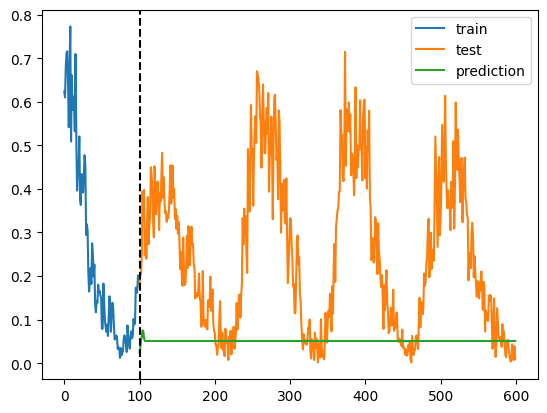

10 steps horizon - rmse = 0.2315
50 steps horizon - rmse = 0.3096
100 steps horizon - rmse = 0.2461
200 steps horizon - rmse = 0.2962
300 steps horizon - rmse = 0.2948
653 steps horizon - rmse = 0.2411


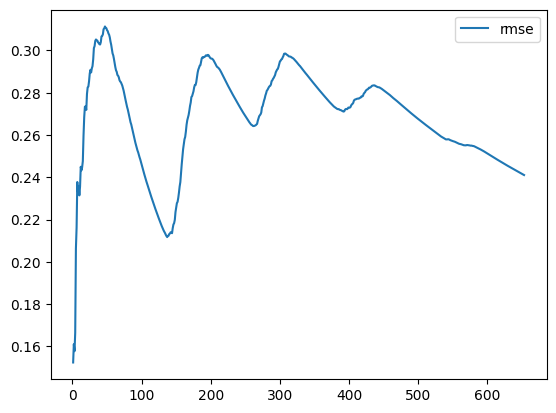


******************************

DATASET.ELECTRICITY


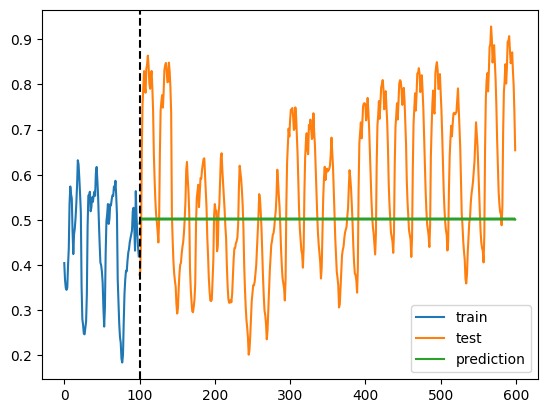

10 steps horizon - rmse = 0.2414
50 steps horizon - rmse = 0.2437
100 steps horizon - rmse = 0.1921
200 steps horizon - rmse = 0.1653
300 steps horizon - rmse = 0.1579
1000 steps horizon - rmse = 0.1763
7891 steps horizon - rmse = 0.1787


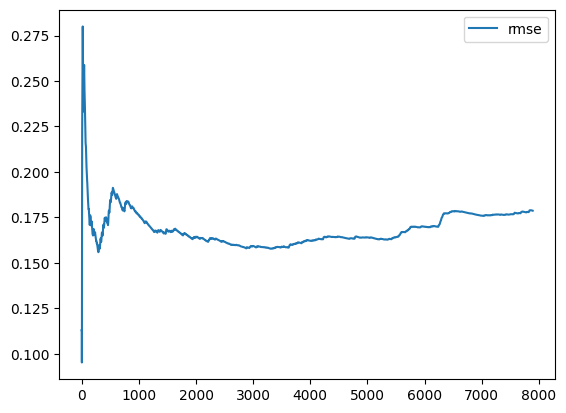


******************************

DATASET.MACKEY_GLASS


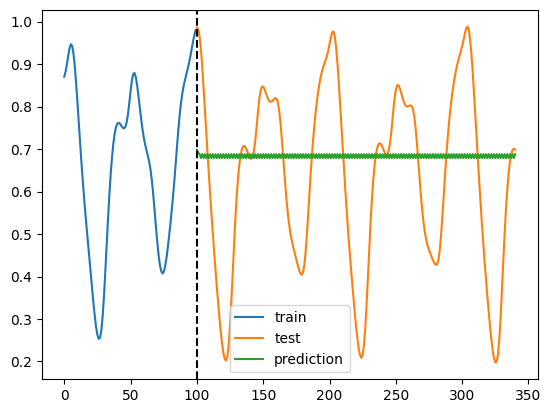

10 steps horizon - rmse = 0.2
50 steps horizon - rmse = 0.2413
100 steps horizon - rmse = 0.2102
200 steps horizon - rmse = 0.2093
241 steps horizon - rmse = 0.2228


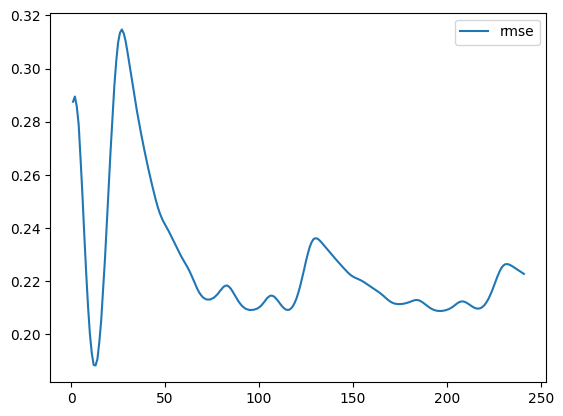


******************************

DATASET.TEMPERATURE


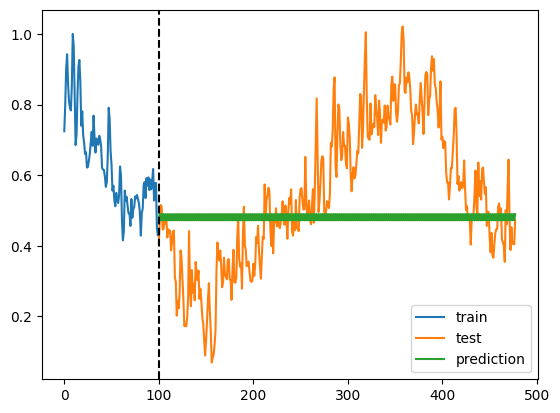

10 steps horizon - rmse = 0.0387
50 steps horizon - rmse = 0.1916
100 steps horizon - rmse = 0.1959
200 steps horizon - rmse = 0.1649
300 steps horizon - rmse = 0.2292
378 steps horizon - rmse = 0.2104


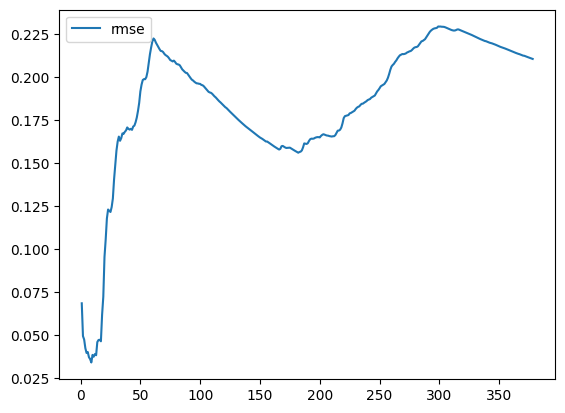


******************************



In [9]:
forecasts = {}
for dataset in datasets:
    y_val = dataset.y_val
    model = models[dataset.name]
    y_pred = model.forecast(y_val)

    print(dataset.name)
    
    plot_predictions(dataset.y_train[-MAX_PLOT_TRAIN: ].flatten(), y_val[:MAX_PLOT_HORIZON].flatten(), y_pred[:MAX_PLOT_HORIZON].flatten())
    plt.show()

    calculate_rmse(y_val.flatten(), y_pred.flatten())
    plt.show()
    print()
    print("*" * 30)
    print()

## **2. Multi-horizon with future covariates**

## Train model

In [9]:
models = {}
datasets = [sunspots, electricity, mackey_glass, temperature]
lightgbm_params = {
    dl.DATASET.SUNSPOTS: {
        "n_estimators": 1000,
        "max_depth": 10,
        "objective": "mse",
        "boosting_type": "gbdt",
        "include_hours": False,
        "lags": {
            "50 years lag": "18262 days",
            "40 years lag": "14610 days",
            "30 years lag": "10958 days"
        },
        "mode": 3
    },
    dl.DATASET.ELECTRICITY: {
        "n_estimators": 1000,
        "max_depth": 5,
        "objective": "mse",
        "boosting_type": "gbdt",
        "include_hours": True,
        "lags": {
            "8 months lag": "242 days",
            "6 months lag": "182 days",
            "4 months lag": "91 days"
        },
        "mode": 3
    },
    dl.DATASET.MACKEY_GLASS: {
        "n_estimators": 100,
        "max_depth": 10,
        "objective": "mse",
        "boosting_type": "gbdt",
        "include_hours": False,
        "lags": {
            "300 days lag": "300 days",
            "2 months lag": "61 days",
            "3 months lag": "91 days"
        },
        "mode": 3
    },
    dl.DATASET.TEMPERATURE: {
       "n_estimators": 1000,
        "max_depth": 5,
        "objective": "mse",
        "boosting_type": "gbdt",
        "include_hours": False,
        "lags": {
            "4 months lag": "91 days",
            "1 months lag": "30 days",
            "15 days lag": "15 days"
        },
        "mode": 3
    }
}

for dataset in datasets:
    print(dataset.name)
    df_train = dataset.y_train_df
    print(df_train.shape)
    params = lightgbm_params[dataset.name]
    model = predictors.LightGBMPredictor(**params)
    model.fit(df_train)
    models[dataset.name] = model    

DATASET.SUNSPOTS
(2612, 2)
DATASET.ELECTRICITY
(31564, 2)
DATASET.MACKEY_GLASS
(960, 2)
DATASET.TEMPERATURE
(1509, 2)


## Evaluate model

DATASET.SUNSPOTS


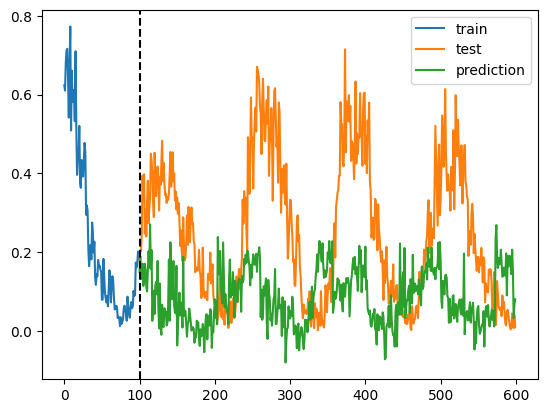

10 steps horizon - rmse = 0.1525
50 steps horizon - rmse = 0.2702
100 steps horizon - rmse = 0.2325
200 steps horizon - rmse = 0.2725
300 steps horizon - rmse = 0.268
653 steps horizon - rmse = 0.2242


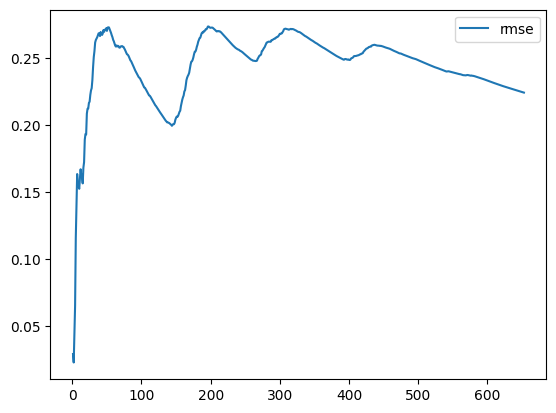


******************************

DATASET.ELECTRICITY


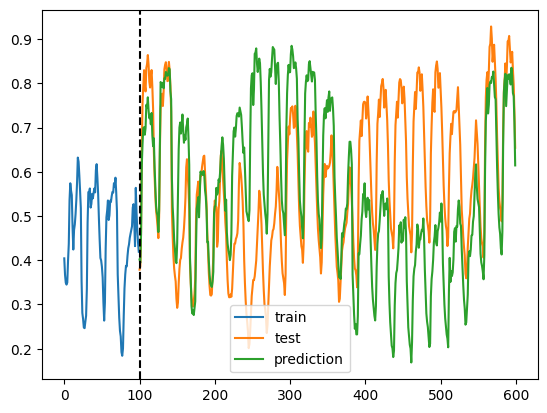

10 steps horizon - rmse = 0.079
50 steps horizon - rmse = 0.0618
100 steps horizon - rmse = 0.1013
200 steps horizon - rmse = 0.1982
300 steps horizon - rmse = 0.1756
1000 steps horizon - rmse = 0.1479
7891 steps horizon - rmse = 0.1287


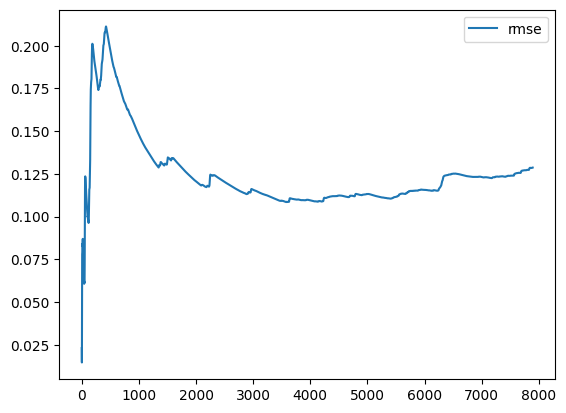


******************************

DATASET.MACKEY_GLASS


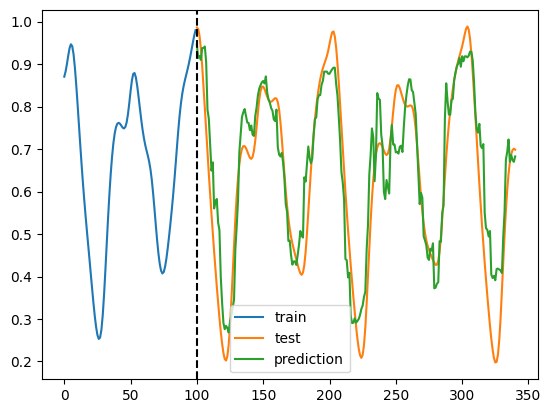

10 steps horizon - rmse = 0.0966
50 steps horizon - rmse = 0.0948
100 steps horizon - rmse = 0.0815
200 steps horizon - rmse = 0.0817
241 steps horizon - rmse = 0.0892


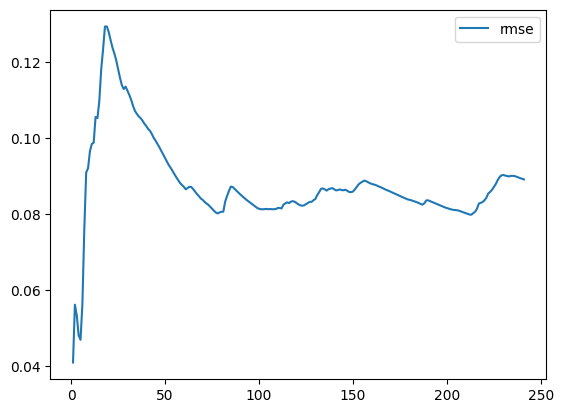


******************************

DATASET.TEMPERATURE


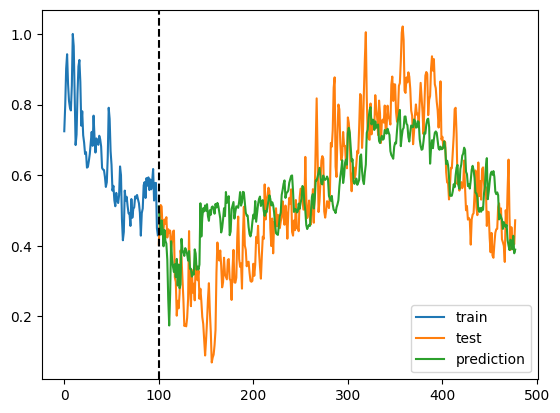

10 steps horizon - rmse = 0.0596
50 steps horizon - rmse = 0.1487
100 steps horizon - rmse = 0.1847
200 steps horizon - rmse = 0.1517
300 steps horizon - rmse = 0.1445
378 steps horizon - rmse = 0.1371


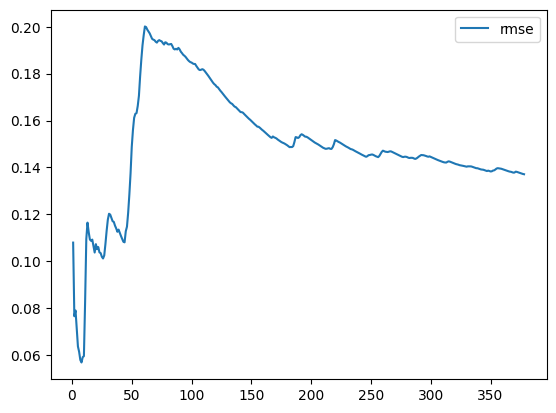


******************************



In [10]:
forecasts = {}
for dataset in datasets:
    y_val = dataset.y_val
    df_val = pd.DataFrame({"ds": dataset.y_val_df.ds})
    model = models[dataset.name]
    y_pred = model.forecast(df_val)

    print(dataset.name)
    
    plot_predictions(dataset.y_train[-MAX_PLOT_TRAIN: ].flatten(), y_val[:MAX_PLOT_HORIZON].flatten(), y_pred[:MAX_PLOT_HORIZON].flatten())
    plt.show()

    calculate_rmse(y_val.flatten(), y_pred.flatten())
    plt.show()
    print()
    print("*" * 30)
    print()